In [219]:
import numpy as np
import pandas as pd
from math import *
from sklearn.ensemble import RandomForestClassifier
from sklearn.datasets import make_classification

In [231]:
X_train = np.load('X_train.npy')
y_train = pd.read_csv('y_train.csv')
X_test = np.load('X_test_public.npy')

In [66]:
y = y_train

In [58]:
pd.DataFrame(X_train[0])

,0,1,2
0,-0.092609,0.321043,0.757579
1,0.023792,0.279446,0.660008
2,0.132476,-0.312948,0.489708
3,0.142232,-0.432489,0.486110
4,-0.011514,-0.054033,0.298357
...,...,...,...
995,0.189953,0.183174,0.630966
996,0.314208,0.009252,0.504889
997,0.301959,-0.029188,0.495712
998,0.020986,0.075646,0.443256


In [63]:
X = X_train

Fonctions pour features :

In [160]:
def surface_au_sol(meuble):
    S=0
    for coord in meuble :
        if coord[2] < 0.01 :
            S+=1
    return(S)

In [169]:
def nombre_de_pied(meuble): 
    S=0
    L=[]
    for coord in meuble :
        if coord[2] < 0.01 :
            personne_autour = True
            for deja_la in L:
                dist = sqrt( (deja_la[0]-coord[0])**2 + (deja_la[1]-coord[1])**2 + (deja_la[1]-coord[1])**2)
                if dist < 0.2 : 
                    personne_autour = False
            if personne_autour :
                L += [coord]
                S += 1
    return(S)


In [262]:
def surface_au_plafond(meuble):
    S=0
    for coord in meuble :
        if coord[2] > 0.99 :
            S+=1
    return(S)

In [334]:
def ecart_type_hauteur(meuble): 
    L=[0]*10
    for coord in meuble :
        for k in range(10):
            if 0.1*k < coord[2] < (0.1*k +0.1)  :
                L[k] +=1
    return( np.array(L).std() )

In [403]:
def ecart_type_lateral1(meuble): 
    L=[0]*10
    for coord in meuble :
        for k in range(10):
            if 0.1*k < coord[1] < (0.1*k + 0.1)  :
                L[k] +=1
    return( np.array(L).std() )

In [429]:
def ecart_type_lateral2(meuble): 
    L=[0]*10
    for coord in meuble :
        for k in range(10):
            if 0.1*k < coord[0] < (0.1*k + 0.1)  :
                L[k] +=1
    return( np.array(L).std() )

In [455]:
def compute_lower_half(meuble):
    z = meuble[:, 2]
    midpoint = z.min() + (z.max() - z.min())/2
    return (z<=midpoint).mean()

In [503]:
def compute_sphericality(meuble):
    """Compute a sphericality score on a meuble.
    """
    # Covariance matrix between the three spatial dimensions
    cov = np.cov(meuble.T)
    
    # Eigenvalues of the covariance matrix.
    eigenvalues, _ = np.linalg.eig(cov)
    
    # Compare the lowest eigenvalue to the sum of all of them.
    # Multiply by 3 to get a score between 0 and 1.
    return 3 * eigenvalues.min() / (eigenvalues.sum())

Pour tester les fonctions : 

inside_chair  
la surface au sol est 7 
le nombre de pied est 4 
la surface au plafond est 11 
la dispersion en hauteur est 90.9470175431828 
la dispersion latérale 1 est 76.0589245256597 
la dispersion latérale 2 est 64.13267497929586 
les points en bas sont  0.222 
la spéricité est  0.45015499213850346


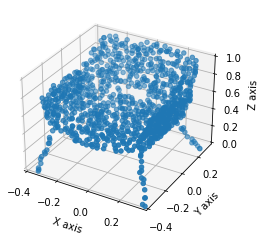

In [508]:
# Run this cell to get a new random sample
i = np.random.choice(len(X))
print(y['y'][i],' \nla surface au sol est', surface_au_sol(X[i]),
      '\nle nombre de pied est',nombre_de_pied(X[i]),
      '\nla surface au plafond est', surface_au_plafond(X[i]),
      '\nla dispersion en hauteur est', ecart_type_hauteur(X[i]),
      '\nla dispersion latérale 1 est', ecart_type_lateral1(X[i]),
     '\nla dispersion latérale 2 est', ecart_type_lateral2(X[i]),
      '\nles points en bas sont ', compute_lower_half(X[i]),
      '\nla spéricité est ', compute_sphericality(X[i])
     ) 
plot_points(X[i])

Création Dataframe avec les features : 

In [567]:
pieds=[]
for i in range(len(X)):
    pieds += [nombre_de_pied(X[i])]
pieds = pd.DataFrame(pieds)
Features = pieds

In [568]:
def fonctionappliquee(fonction,X):
    pieds=[]
    for i in range(len(X)):
        pieds += [fonction(X[i])]
    return(pieds)

In [569]:
Features.insert(1, 'surface_au_sol', fonctionappliquee(surface_au_sol,X_train))
Features.insert(2, 'surface_au_plafond', fonctionappliquee(surface_au_plafond,X_train))
Features.insert(3, 'dispersion en hauteur', fonctionappliquee(ecart_type_hauteur,X_train))
Features.insert(4, 'dispersion latérale 1', fonctionappliquee(ecart_type_lateral1,X_train))
Features.insert(5, 'points en bas', fonctionappliquee(compute_lower_half,X_train))
Features.insert(6, 'sphere', fonctionappliquee(compute_sphericality,X_train))

In [570]:
Features.columns = ['nombre de pieds', 'surface au sol','surface au plafond',
                    'dispersion en hauteur','dispersion latérale','points en bas','sphere']
Features

,nombre de pieds,surface au sol,surface au plafond,dispersion en hauteur,dispersion latérale,points en bas,sphere
0,9,92,7,74.849248,61.368477,0.612,0.468782
1,4,7,358,142.089971,4.939636,0.056,0.139945
2,5,75,16,63.300553,110.731432,0.423,0.145886
3,33,129,212,31.844780,4.295346,0.417,0.187489
4,3,6,16,110.504344,96.579294,0.175,0.425339
...,...,...,...,...,...,...,...
810,7,167,15,64.701236,83.190685,0.570,0.204233
811,73,320,2,48.349664,3.944617,0.638,0.201493
812,20,96,160,49.932855,3.606938,0.348,0.433907
813,4,207,20,126.369933,118.054902,0.569,0.021686


In [571]:
scaler = StandardScaler()
Features = pd.DataFrame(scaler.fit_transform(Features))
Features

,0,1,2,3,4,5,6
0,-0.017627,0.678535,-0.616152,-0.365429,0.030968,0.870267,0.471097
1,-0.281705,-0.532541,1.992049,1.662446,-1.266254,-1.852488,-1.148585
2,-0.228890,0.436320,-0.549275,-0.713720,1.165754,-0.055273,-1.119325
3,1.249950,1.205709,0.907156,-1.662377,-1.281065,-0.084656,-0.914407
4,-0.334521,-0.546789,-0.549275,0.709873,0.840416,-1.269740,0.257121
...,...,...,...,...,...,...,...
810,-0.123258,1.747131,-0.556706,-0.671477,0.532630,0.664592,-0.831938
811,3.362578,3.927068,-0.653306,-1.164615,-1.289128,0.997590,-0.845431
812,0.563346,0.735527,0.520756,-1.116869,-1.296891,-0.422552,0.299321
813,-0.281705,2.317049,-0.519552,1.188354,1.334110,0.659695,-1.731072


Modèle : 

In [572]:
from sklearn.neighbors import NearestNeighbors
from xgboost import XGBClassifier
model = RandomForestClassifier()
#model = XGBClassifier()

In [573]:
%time

model.fit(Features,y['y'])

CPU times: user 8 µs, sys: 1 µs, total: 9 µs
Wall time: 16.2 µs


RandomForestClassifier()

In [574]:
print('Notre modèle a un score de',model.score(Features.tail(200),y.tail(200)['y']))

Notre modèle a un score de 1.0


Score on test set: 1.0


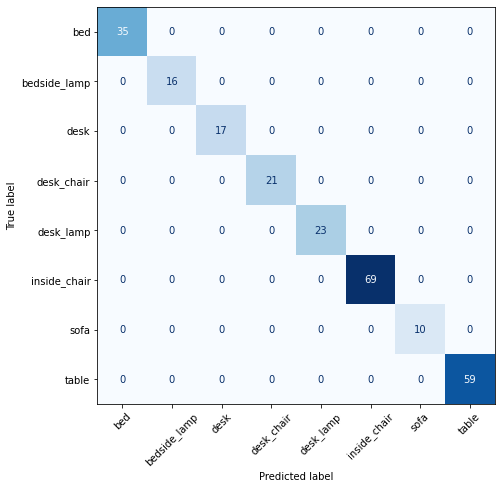

In [575]:
y_pred = model.predict(Features.tail(250))

# Print the score
print("Score on test set:", balanced_accuracy_score(y['y'].tail(250), y_pred))

# Plot confusion matrix
fig, ax = plt.subplots(figsize=(7, 7))
plot_confusion_matrix(model,Features.tail(250), y['y'].tail(250), cmap="Blues", colorbar=False, ax=ax)
plt.xticks(rotation=45)
plt.tight_layout()

In [243]:
X_test.shape

(277, 1000, 3)

pour le X_test : 

In [576]:
pieds=[]
for i in range(len(X_test)):
    pieds += [nombre_de_pied(X_test[i])]
pieds = pd.DataFrame(pieds)
Featurestest = pieds

Featurestest.insert(1, 'surface_au_sol', fonctionappliquee(surface_au_sol,X_test))
Featurestest.insert(2, 'surface_au_plafond', fonctionappliquee(surface_au_plafond,X_test))
Featurestest.insert(3, 'dispersion en hauteur', fonctionappliquee(ecart_type_hauteur,X_test))
Featurestest.insert(4, 'dispersion latérale', fonctionappliquee(ecart_type_lateral1,X_test))
Featurestest.insert(5, 'points en bas', fonctionappliquee(compute_lower_half,X_test))
Featurestest.insert(6, 'sphere', fonctionappliquee(compute_sphericality,X_test))

Featurestest.columns = ['nombre de pieds', 'surface au sol','surface au plafond',
                        'dispersion en hauteur','dispersion latérale','points en bas','sphere']
scaler = StandardScaler()
Featurestest = pd.DataFrame(scaler.fit_transform(Featurestest))
Featurestest

,0,1,2,3,4,5,6
0,-0.348112,-0.466799,-0.562420,0.014085,2.156623,1.171431,0.838468
1,-0.268089,-0.482325,-0.536299,-0.222815,0.596222,0.558434,0.886158
2,-0.268089,-0.497851,-0.568951,-0.153012,0.501627,-0.785256,0.715008
3,-0.508157,-0.591009,-0.425281,-0.932824,-1.240291,1.401918,-1.104523
4,-0.108045,3.601099,-0.608133,1.449199,0.858022,0.538818,-1.415089
...,...,...,...,...,...,...,...
272,-0.428134,-0.249430,-0.608133,-1.479227,0.550011,-0.392938,0.457151
273,-0.268089,-0.528904,-0.562420,0.879551,0.553344,-0.652849,-0.282348
274,-0.268089,-0.451272,-0.503646,-0.500232,0.947116,-0.147739,1.940005
275,-0.268089,-0.466799,-0.568951,0.182573,0.542553,0.622186,0.088705


In [579]:
y_pred = model.predict(Featurestest)
pd.Series(y_pred).to_csv("submission.csv", index=False)

In [591]:
def Rendu_final(X_test,X_train,y_train): 
    
    y=y_train
    pieds=[]
    for i in range(len(X_train)):
        pieds += [nombre_de_pied(X_train[i])]
        
    pieds = pd.DataFrame(pieds)
    Features = pieds.copy()
    
    Features.insert(1, 'surface_au_sol', fonctionappliquee(surface_au_sol,X_train))
    Features.insert(2, 'surface_au_plafond', fonctionappliquee(surface_au_plafond,X_train))
    Features.insert(3, 'dispersion en hauteur', fonctionappliquee(ecart_type_hauteur,X_train))
    Features.insert(4, 'dispersion latérale 1', fonctionappliquee(ecart_type_lateral1,X_train))
    Features.insert(5, 'points en bas', fonctionappliquee(compute_lower_half,X_train))
    Features.insert(6, 'sphere', fonctionappliquee(compute_sphericality,X_train))
    
    Features.columns = ['nombre de pieds', 'surface au sol','surface au plafond',
                    'dispersion en hauteur','dispersion latérale','points en bas','sphere']
    
    scaler = StandardScaler()
    Features = pd.DataFrame(scaler.fit_transform(Features))
    
    
    model = RandomForestClassifier()
    model.fit(Features,y['y'])
    
    pieds=[]
    for i in range(len(X_test)):
        pieds += [nombre_de_pied(X_test[i])]
    pieds = pd.DataFrame(pieds)
    Featurestest = pieds

    Featurestest.insert(1, 'surface_au_sol', fonctionappliquee(surface_au_sol,X_test))
    Featurestest.insert(2, 'surface_au_plafond', fonctionappliquee(surface_au_plafond,X_test))
    Featurestest.insert(3, 'dispersion en hauteur', fonctionappliquee(ecart_type_hauteur,X_test))
    Featurestest.insert(4, 'dispersion latérale', fonctionappliquee(ecart_type_lateral1,X_test))
    Featurestest.insert(5, 'points en bas', fonctionappliquee(compute_lower_half,X_test))
    Featurestest.insert(6, 'sphere', fonctionappliquee(compute_sphericality,X_test))

    Featurestest.columns = ['nombre de pieds', 'surface au sol','surface au plafond',
                            'dispersion en hauteur','dispersion latérale','points en bas','sphere']
    scaler = StandardScaler()
    Featurestest = pd.DataFrame(scaler.fit_transform(Featurestest))
    Featurestest
    y_pred = model.predict(Featurestest)
    pd.Series(y_pred).to_csv("submission.csv", index=False)

In [592]:
Rendu_final(X_test,X_train,y_train)

CPU times: user 9 µs, sys: 0 ns, total: 9 µs
Wall time: 16.9 µs
